## Set-up

In [55]:
import sys
import os
sys.path.append(os.path.abspath('..')) # for importing from python files not in the same directory

import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import pickle

import numpy as np
from tqdm.notebook import trange

sns.set_theme()
colors = sns.color_palette("deep")

# Custom
%load_ext autoreload
%autoreload explicit
%aimport utils
from utils import geometric_median, geometric_medoid, month_to_season, plot_components, normalize_curves, functional_norm
from itertools import permutations, product

# HOTFIX Parse IMCEI
import locale
locale.setlocale(locale.LC_ALL, 'it_IT')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'it_IT'

In [56]:
def align_components(H_results, W_results, A, models, ref_idx=0):
    # Align the components
    n_comp, n_eval_points, n_runs = H_results.shape
    ref_H = H_results[..., ref_idx]

    for n in range(1, n_runs):

        best_permutation = list(range(n_comp))
        eval_points = np.arange(0, n_eval_points, int(n_eval_points / 24))
        best_alignment = np.linalg.norm(ref_H - H_results[..., n][range(n_comp), :], 'fro')

        sources_groups = [np.nonzero(A[:, i])[0] for i in range(A.shape[1])]
        valid_permutations = product(*[permutations(a) for a in sources_groups])
        valid_permutations = [[item for subtuple in permutation for item in subtuple] for permutation in valid_permutations]
        for permutation in valid_permutations:
            alignment = np.linalg.norm(ref_H - H_results[..., n][list(permutation)[:n_comp], :], 'fro')

            if alignment < best_alignment:
                best_alignment = alignment
                best_permutation = list(permutation)

        H_results[..., n] = H_results[..., n][best_permutation, :]
        W_results[..., n] = W_results[..., n][:, best_permutation]
        model = models[n]
        model.components_ = model.components_[best_permutation, :]
        models[n] = model

In [58]:
n_components = 5 # Number of components for the matrix factorization
n_runs = 1000
smoothed = False
smooth_param = ''
specific = '_Italy'
alpha = 3e-10
beta = 1

train_years = ['2021']
seasons = ['Spring', 'Fall', 'Winter', 'Summer']

colormap = ListedColormap([colors[k] for k in range(n_components)])

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

# Process data

## Data matrix $X$

In [59]:
infile = f'../data/2_processed/daily_curves{specific}{smoothed * smooth_param}.csv'
input_df = pd.read_csv(infile, index_col=0)
print(len(input_df))
input_df.head(3)

2191


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2018-01-01_Holiday,24743.000,23797.000,22175.999,21042.000,20146.999,20079.000,20942.001,21712.000,21969.999,22967.000,...,26643.000,26807.000,29947.001,31103.000,31537.000,30804.001,29621.000,27749.000,25388.000,22714.001
Italy_2018-01-02_Working day,22714.001,20794.001,19802.002,19573.002,19679.000,20891.000,24197.999,28537.000,32988.000,37794.999,...,36511.999,37393.000,41395.000,42362.001,42081.001,39555.000,37163.000,33313.000,29811.000,26314.001
Italy_2018-01-03_Working day,26314.001,24248.999,22927.999,22537.999,22314.001,23529.001,27206.000,32970.999,37419.000,40908.999,...,40106.999,40662.001,44557.000,44708.000,43818.999,41347.000,38572.999,34229.001,30436.999,27199.000


In [60]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
unit_info['season'] = unit_info.month.astype(int).map(month_to_season)
df = pd.concat([input_df, unit_info], axis=1)
df = df[df.year.isin(train_years)]
df = df[df.season.isin(seasons)]
print(len(df))
df.head(3)

365


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,region,year,month,daytype,season
Italy_2021-01-01_Holiday,24375.000,23142.999,21418.001,20136.000,19257.999,19473.999,20382.000,21137.000,21204.001,22809.999,...,30031.000,28681.0,27158.999,24913.000,22807.000,Italy,2021,01,Holiday,Winter
Italy_2021-01-02_Saturday,22807.000,21146.000,20085.000,19431.001,19543.000,20095.000,22104.000,23960.001,25809.999,28031.999,...,34347.000,31864.0,29392.999,26308.999,23326.001,Italy,2021,01,Saturday,Winter
Italy_2021-01-03_Holiday,23326.001,21322.000,20397.999,19543.001,19229.000,19879.000,21032.999,22168.000,23240.000,25000.999,...,32547.001,30280.0,28256.999,25917.000,23235.001,Italy,2021,01,Holiday,Winter


In [61]:
X = df.drop(unit_info.columns, axis=1)
X = normalize_curves(X)
p = len(X.columns)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2021-01-01_Holiday,0.040804,0.038742,0.035854,0.033708,0.032238,0.032600,0.034120,0.035383,0.035496,0.038184,...,0.042573,0.043251,0.047590,0.048918,0.050168,0.050272,0.048012,0.045464,0.041705,0.038179
Italy_2021-01-02_Saturday,0.034414,0.031907,0.030306,0.029319,0.029488,0.030321,0.033353,0.036153,0.038945,0.042298,...,0.044727,0.045919,0.050289,0.052199,0.053566,0.051826,0.048080,0.044351,0.039698,0.035197
Italy_2021-01-03_Holiday,0.037353,0.034144,0.032665,0.031295,0.030793,0.031833,0.033681,0.035499,0.037216,0.040036,...,0.043765,0.044670,0.049144,0.051261,0.052497,0.052119,0.048489,0.045250,0.041502,0.037208
Italy_2021-01-04_Monday,0.029707,0.027360,0.026213,0.026345,0.026738,0.027907,0.031743,0.037142,0.042662,0.047633,...,0.049228,0.049020,0.052170,0.052683,0.052748,0.049429,0.045780,0.041584,0.037839,0.033934
Italy_2021-01-05_Working day,0.032900,0.030340,0.028683,0.028162,0.028115,0.029145,0.032760,0.038128,0.043562,0.047061,...,0.048094,0.048353,0.051152,0.051067,0.050467,0.048227,0.044795,0.041040,0.036631,0.032362


## NMF

In [62]:
# Load the arrays from the .npz file
name = ''
arrays_path = f"../data/3_output/pennmf_results/batch/{n_components}comp{smoothed * smooth_param}_alpha_{alpha}_beta_{beta}_{'_'.join(train_years)}_{n_runs}runs{name}.npz"
estimator_path = arrays_path.replace('.npz', '.pkl')
data = np.load(arrays_path)
with open(estimator_path, 'rb') as file:
    estimators = pickle.load(file)
print('Loaded ', arrays_path)
print('Loaded ', estimator_path)

Loaded  ../data/3_output/pennmf_results/batch/5comp_alpha_3e-10_beta_1_2021_1000runs.npz
Loaded  ../data/3_output/pennmf_results/batch/5comp_alpha_3e-10_beta_1_2021_1000runs.pkl


In [63]:
# Access the arrays
C_results = data['C_results']
S_results = data['S_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint_c = data['loss_constraint_c']
loss_constraint_s = data['loss_constraint_s']

In [64]:
pd.Series(iterations).quantile(np.linspace(0,1,11))

0.0    1000.0
0.1    1490.0
0.2    1580.0
0.3    1680.0
0.4    1800.0
0.5    1940.0
0.6    2100.0
0.7    2420.0
0.8    2910.0
0.9    3501.0
1.0    5550.0
dtype: float64

In [65]:
# Remove results for which we have less than 100 iterations (they correspond to a local minima where all profile are the same)
S_results = S_results[..., iterations > 100]
C_results = C_results[..., iterations > 100]
estimators = [estimator for estimator, select in zip(estimators, iterations > 100) if select]
loss_nmf = loss_nmf[iterations > 100]
loss_constraint_c = loss_constraint_c[iterations > 100]
loss_constraint_s = loss_constraint_s[iterations > 100]
iterations = iterations[iterations > 100]
print('{} results clean'.format(C_results.shape[2]))

1000 results clean


In [66]:
n_clean_runs = C_results.shape[2]
abscissa = [float(x) for x in X.columns]

<Axes: >

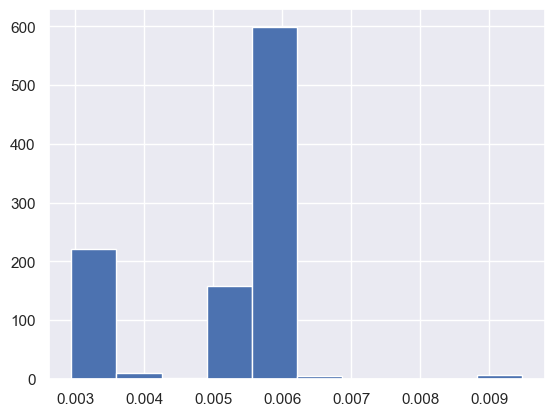

In [67]:
pd.Series(loss_nmf).hist()

In [71]:
# HOTFIX: Remove results for which the NMF loss is in the high group
# threshold = 0.015
threshold = 0.004

S_results = S_results[..., loss_nmf < threshold]
C_results = C_results[..., loss_nmf < threshold]
iterations = iterations[loss_nmf < threshold]
loss_constraint_c = loss_constraint_c[loss_nmf < threshold]
loss_constraint_s = loss_constraint_s[loss_nmf < threshold]
estimators = [estimator for estimator, select in zip(estimators, loss_nmf < threshold) if select]
loss_nmf = loss_nmf[loss_nmf < threshold]
n_clean_runs = C_results.shape[2]
print('{} results clean'.format(n_clean_runs))

231 results clean


In [72]:
# Align solutions to have comp x of solution i matching comp x of solution j
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

# A = np.array([
#     [1, 0, 0],
#     [0, 1, 0],
#     [0, 0, 1],
# ])


align_components(S_results, C_results, A, estimators, ref_idx=0)

## Quick data check

Check-plots on the solutions found

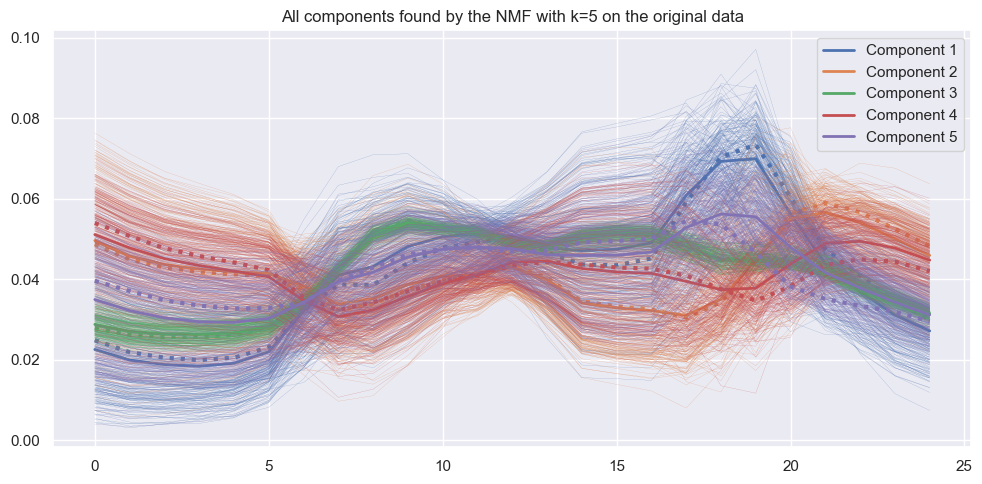

In [73]:
fig, ax = plt.subplots(figsize=(10, 5))

for k in range(n_components):
    for i in range(n_clean_runs):
        line, = ax.plot(abscissa, S_results[k, :, i], linewidth=0.1, color=colors[k])
    label = f'Component {k + 1}'
    ax.plot(abscissa, geometric_median(S_results[k, ...].T), linewidth=2, color=colors[k], label=label)
    ax.plot(abscissa, geometric_medoid(S_results[k, ...].T), linewidth=3, linestyle='dotted', color=colors[k])
ax.set_title(f"All components found by the NMF with k={n_components} on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
ax.legend()
plt.tight_layout()

Let's plot separately per component

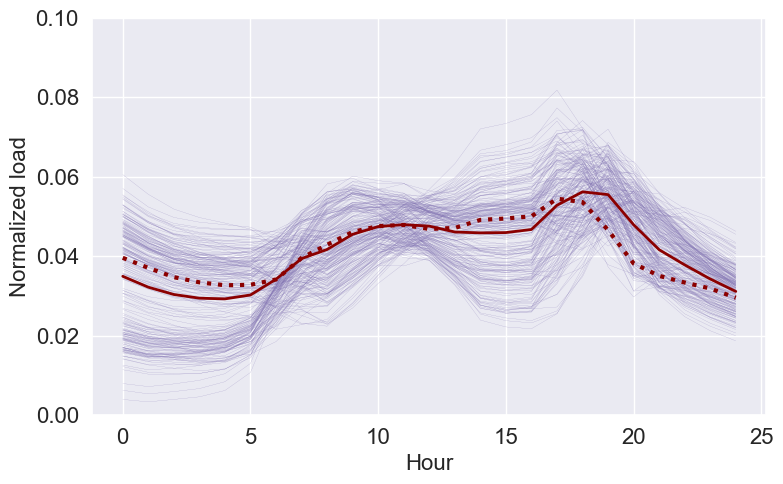

In [79]:
k = 4
fontsize = 16
# source_colors = [colors[np.nonzero(A[k, :])[0][0]] for k in range(n_components)]
source_colors = colors

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(n_clean_runs):
    line, = ax.plot(abscissa, S_results[k, :, i], linewidth=0.1, color=colors[k])
ax.plot(abscissa, geometric_median(S_results[k, ...].T), linewidth=2, color='darkred')
ax.plot(abscissa, geometric_medoid(S_results[k, ...].T), linewidth=3, linestyle='dotted', color='darkred')
# ax.set_title(f"Component {k + 1} found by the NMF with $K={n_components}$ on the {(1-smoothed)*'original' + smoothed*'smoothed'} data")
ax.set_xlabel('Hour', fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel('Normalized load', fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
plt.ylim((0, 0.1))
plt.tight_layout()

# Selection of the optimal solution

In [81]:
criteria_df = pd.DataFrame({
    'loss_nmf': loss_nmf,
    'loss_constraint_c': loss_constraint_c,
    'loss_constraint_s': loss_constraint_s,
})
criteria_df

,loss_nmf,loss_constraint_c,loss_constraint_s
0,0.003330,221572.329068,9.113127e-09
1,0.003008,65540.072673,2.478389e-09
2,0.003328,171350.214152,3.960010e-08
3,0.003185,226774.945580,3.211132e-09
4,0.003640,116911.692591,2.540548e-08
...,...,...,...
226,0.003094,64743.313450,2.430450e-09
227,0.003585,184255.719315,1.687111e-08
228,0.003402,130037.954037,2.649584e-08
229,0.003203,92482.806213,1.044386e-08


In [82]:
# Create a scatter plot
fig = px.scatter(
    criteria_df,
    x='loss_nmf',
    y='loss_constraint_c',
    hover_name=criteria_df.index,
    title='Scatter Plot of Loss NMF vs. Loss Constraint on C'
)

# Update layout
fig.update_layout(
    height=500,
    width=500,
    xaxis_title='Loss NMF',
    yaxis_title='Loss Constraint on C'
)

fig.update_traces(selected=dict(marker=dict(color='red')))

# Show plot
fig.show()

In [83]:
# Save all clean solutions
outfile_arrays = f"../data/3_output/pennmf_results/batch_clean/clean_results_{n_components}comp_{n_runs}runs_{'_'.join(train_years)}.npz"
outfile_estimators = outfile_arrays.replace('.npz', '.pkl')

np.savez(outfile_arrays, S_results=S_results, C_results=C_results, iterations=iterations, loss_nmf=loss_nmf, loss_constraint_c=loss_constraint_c, loss_constraint_s=loss_constraint_s)
with open(outfile_estimators, 'wb') as file:
    pickle.dump(estimators, file)

## Optimal solution

In [25]:
opt_idx = (loss_nmf + alpha * loss_constraint_c + beta * loss_constraint_s).argmin()
opt_idx

4

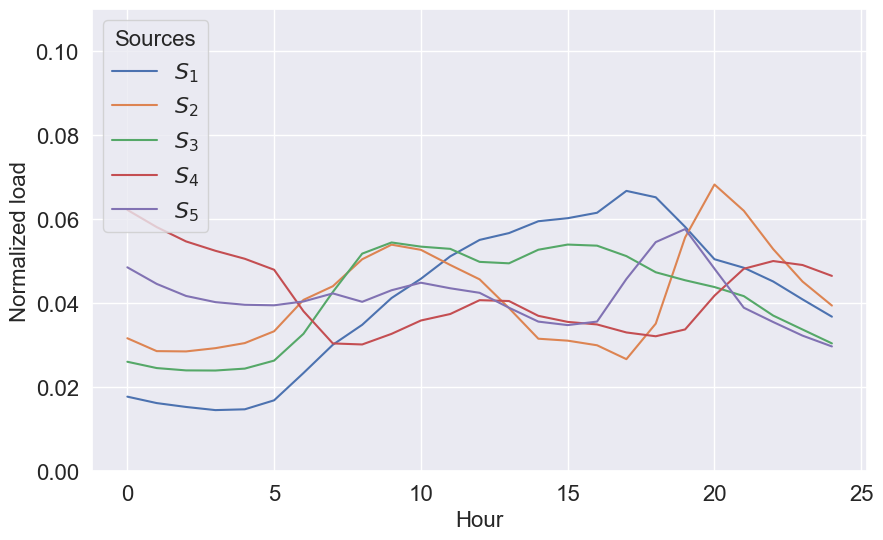

In [84]:
# Solution with minimum loss
best_run = 72
fontsize = 16

H = S_results[..., best_run]
C = C_results[..., best_run]
fig, ax = plot_components(H)
ax.set_xlabel('Hour', fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel('Normalized load', fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
# Add the legend
ax.legend(title='Sources', fontsize=fontsize, title_fontsize=fontsize, loc='upper left')
ylim = ax.set_ylim(bottom=0, top=0.11)

# Analysis of the solution

In [85]:
C = pd.DataFrame(C, index=df.index, columns=[f"$S_{k+1}$" for k in range(n_components)])
C[unit_info.columns] = df[unit_info.columns]
C['season'] = C.month.astype(int).map(month_to_season)
C

,$S_1$,$S_2$,$S_3$,$S_4$,$S_5$,region,year,month,daytype,season
Italy_2021-01-01_Holiday,0.352519,0.088177,0.005090,0.326145,0.228898,Italy,2021,01,Holiday,Winter
Italy_2021-01-02_Saturday,0.400847,0.167378,0.023604,0.126024,0.281465,Italy,2021,01,Saturday,Winter
Italy_2021-01-03_Holiday,0.385603,0.140596,0.007686,0.221640,0.244977,Italy,2021,01,Holiday,Winter
Italy_2021-01-04_Monday,0.329332,0.120703,0.314035,0.035461,0.200263,Italy,2021,01,Monday,Winter
Italy_2021-01-05_Working day,0.241772,0.072807,0.381681,0.075599,0.227951,Italy,2021,01,Working day,Winter
...,...,...,...,...,...,...,...,...,...,...
Italy_2021-12-27_Monday,0.303094,0.109376,0.364363,0.038710,0.184623,Italy,2021,12,Monday,Fall
Italy_2021-12-28_Working day,0.220446,0.074936,0.410197,0.050410,0.243914,Italy,2021,12,Working day,Fall
Italy_2021-12-29_Working day,0.218813,0.101289,0.357151,0.058075,0.264869,Italy,2021,12,Working day,Fall
Italy_2021-12-30_Working day,0.197423,0.130224,0.352976,0.054190,0.265025,Italy,2021,12,Working day,Fall


In [86]:
df_plot = C.melt(id_vars=unit_info.columns.to_list(), var_name='Sources', value_name='Concentrations')

(-0.03624437884478483, 1.0)

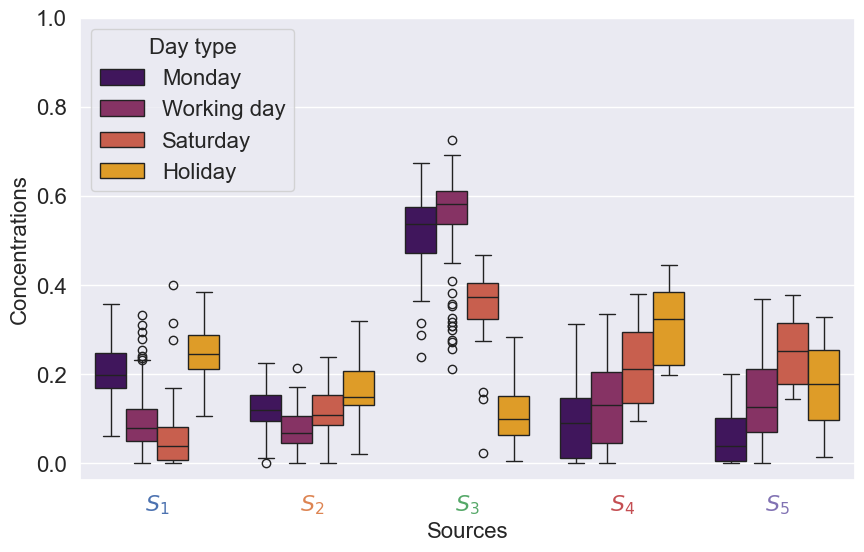

In [87]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=df_plot,
    x='Sources',
    y='Concentrations',
    hue='daytype',
    hue_order=daytype_order,
    palette='inferno'
)

ax.set_xlabel('Sources', fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel('Concentrations', fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
# Add the legend
ax.legend(title='Day type', fontsize=fontsize, title_fontsize=fontsize, loc='upper left')

# Change the color of x-axis labels
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])  # Change this to your desired color

plt.ylim(top=1)

<Axes: xlabel='month', ylabel='Concentrations'>

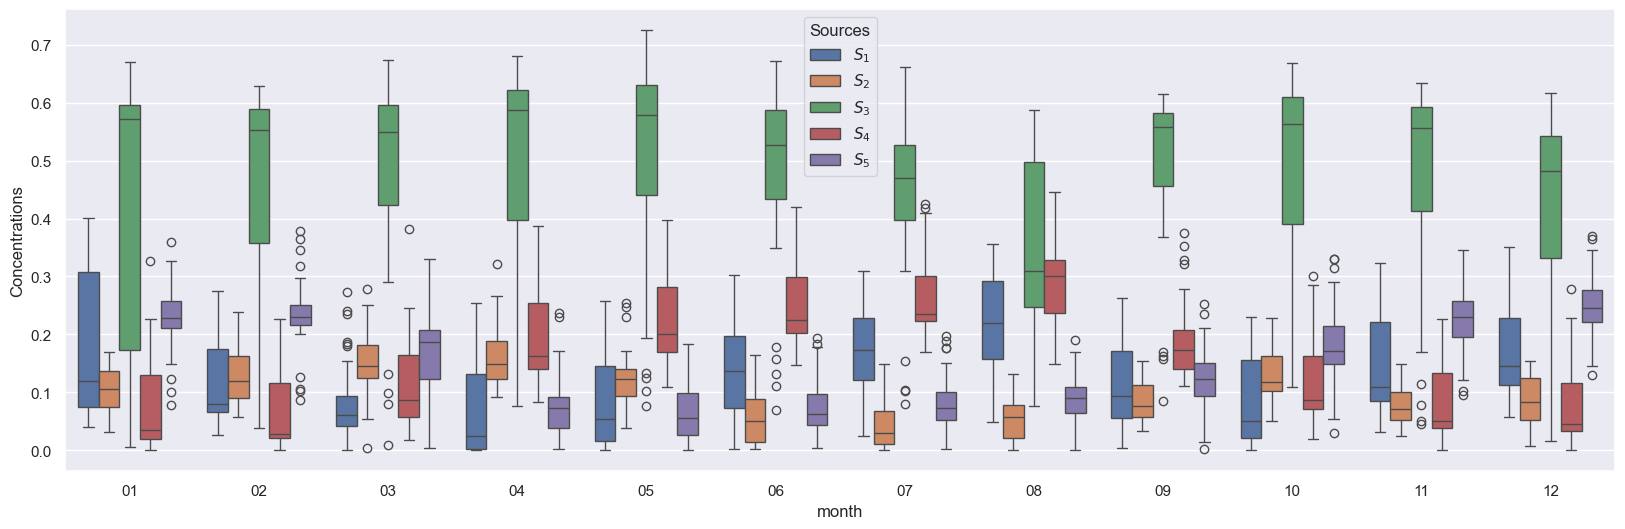

In [88]:
plt.figure(figsize=(20,6))
sns.boxplot(
    data=df_plot,
    x='month',
    y='Concentrations',
    hue='Sources',
)

In [89]:
df_plot

,region,year,month,daytype,season,Sources,Concentrations
0,Italy,2021,01,Holiday,Winter,$S_1$,0.352519
1,Italy,2021,01,Saturday,Winter,$S_1$,0.400847
2,Italy,2021,01,Holiday,Winter,$S_1$,0.385603
3,Italy,2021,01,Monday,Winter,$S_1$,0.329332
4,Italy,2021,01,Working day,Winter,$S_1$,0.241772
...,...,...,...,...,...,...,...
1820,Italy,2021,12,Monday,Fall,$S_5$,0.184623
1821,Italy,2021,12,Working day,Fall,$S_5$,0.243914
1822,Italy,2021,12,Working day,Fall,$S_5$,0.264869
1823,Italy,2021,12,Working day,Fall,$S_5$,0.265025


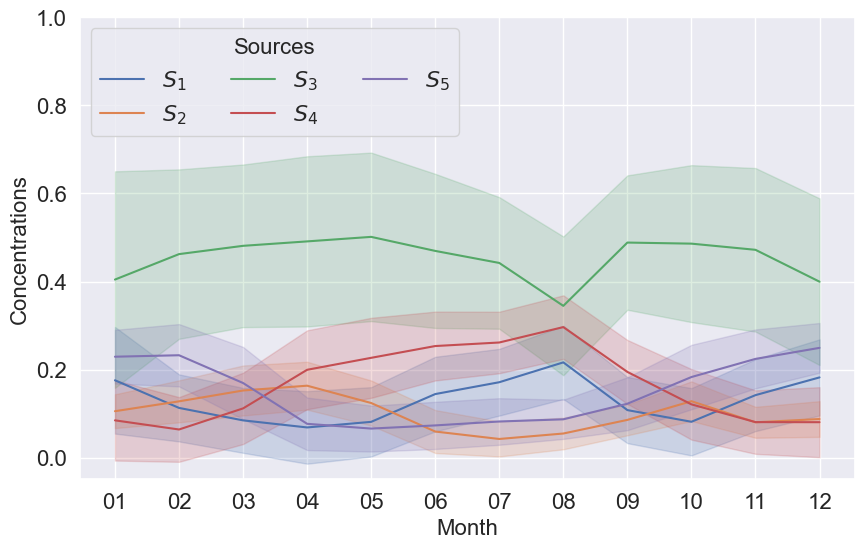

In [90]:
plt.figure(figsize=(10,6))

ax = sns.lineplot(
    data=df_plot,
    x='month',
    y='Concentrations',
    hue='Sources',
    errorbar='sd',
)
ax.set_ylim(top=1)

ax.set_xlabel('Month', fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel('Concentrations', fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
# Add the legend
ax.legend(title='Sources', fontsize=fontsize, title_fontsize=fontsize, loc='upper left', ncols=3)

In [92]:
dimensions = [f'$S_{k+1}$' for k in range(n_components)]
height, width = 1000, 1100

fig = px.scatter_matrix(C, dimensions=dimensions, hover_name=C.index, color='daytype')
fig.update_layout(height=height, width=width)
fig.update_traces(selected=dict(marker=dict(color='yellow')))
fig.show()

## Save results

In [30]:
opt = ''
specific = '_Italy_lambda_3e-10'
outfile_arrays = f"../data/3_output/pennmf_results/WHopt{opt}_{n_components}comp{'_smoothed'*smoothed}_{n_runs}runs_{name}.npz"
np.savez(outfile_arrays, W=C, H=H)
outfile_estimator = f"../data/3_output/pennmf_results/PenNMF_{n_components}comp{'_smoothed'*smoothed}_{n_runs}runs_{name}.pkl"
with open(outfile_estimator, 'wb') as file:
    pickle.dump(estimators[best_run], file)
print("Saved arrays at", outfile_arrays)
print("Saved estimator at", outfile_estimator)

Saved arrays at ../data/3_output/pennmf_results/WHopt_5comp_1000runs_.npz
Saved estimator at ../data/3_output/pennmf_results/PenNMF_5comp_1000runs_.pkl


___

# TESTS